In [1]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [2]:
from torch import empty, Tensor

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

## Testing data generation

In [4]:
train_input, train_target, test_input, test_target, mu, sigma= load_dataset(1000, standardize=True)

<AxesSubplot:xlabel='x', ylabel='y'>

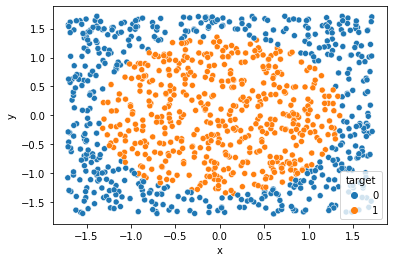

In [6]:
df = pd.DataFrame(train_input.tolist())

df['target'] = train_target.tolist()
df.columns = ['x', 'y', 'target']

sns.scatterplot(data=df, x='x', y='y', hue='target')

## Testing loss

In [7]:
from torch import tensor

In [8]:
from flame.nn import Module


class MSELoss(Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, target):
        
        print(prediction)
        print(target)
        
        self.prediction = prediction.view(-1)
        self.target = target
        return (prediction - target).pow(2).mean()

    def backward(self):
        return 2 * (self.prediction - self.target) / (self.prediction.size(0))

In [9]:
prediction = tensor([[-0.4433],
        [-0.2356],
        [-0.2109],
        [-0.1666],
        [-0.3752],
        [-0.0956],
        [-0.3019],
        [-0.0784],
        [-0.2483],
        [-0.0612]])
target = tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

In [10]:
criterion = MSELoss()

In [11]:
criterion(prediction, target)

tensor([[-0.4433],
        [-0.2356],
        [-0.2109],
        [-0.1666],
        [-0.3752],
        [-0.0956],
        [-0.3019],
        [-0.0784],
        [-0.2483],
        [-0.0612]])
tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1])


tensor(1.0741)

In [12]:
criterion.backward()

tensor([-0.0887, -0.2471, -0.2422, -0.2333, -0.0750, -0.2191, -0.0604, -0.2157,
        -0.2497, -0.2122])

# Evaluate Metrics

In [4]:
import matplotlib as mpl

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 16

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_SIZE
mpl.rcParams['axes.titlesize'] = SMALL_SIZE
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = SMALL_SIZE
mpl.rcParams['figure.titlesize'] = LARGE_SIZE

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.facecolor'] = '#F5F5F5'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = [6, 3.259]

In [17]:
df = pd.read_json('../results/metrics.json')

df['model'] = df['optimizer'] + ' ' + df['criterion'] 

In [18]:
df.head()

,loss,accuracy,epoch,trial,optimizer,criterion,batch_size,learning_rate,test_accuracy,model
0,5.838417,0.596,0,0,SGD,MSE,50,0.1,NaN,SGD MSE
1,3.817331,0.733,1,0,SGD,MSE,50,0.1,NaN,SGD MSE
2,3.020607,0.770,2,0,SGD,MSE,50,0.1,NaN,SGD MSE
3,2.762596,0.774,3,0,SGD,MSE,50,0.1,NaN,SGD MSE
4,2.598195,0.807,4,0,SGD,MSE,50,0.1,NaN,SGD MSE


In [19]:
tt = df[df['epoch'] == 49][['accuracy', 'test_accuracy', 'optimizer', 'criterion']].copy()

In [20]:
table = pd.pivot_table(tt, index=['optimizer', 'criterion'],
                       values=['accuracy', 'test_accuracy'], 
                       aggfunc={'accuracy': [np.mean, np.std], 'test_accuracy': [np.mean, np.std]})

print(table.to_latex(float_format="%.4f"))

\begin{tabular}{llrrrr}
\toprule
    &     & \multicolumn{2}{l}{accuracy} & \multicolumn{2}{l}{test\_accuracy} \\
    &     &     mean &    std &          mean &    std \\
optimizer & criterion &          &        &               &        \\
\midrule
Adagrad & CrossEntropy &   0.8947 & 0.0320 &        0.8916 & 0.0313 \\
    & MSE &   0.9703 & 0.0094 &        0.9668 & 0.0097 \\
Adam & CrossEntropy &   0.9427 & 0.0066 &        0.9437 & 0.0080 \\
    & MSE &   0.9704 & 0.0058 &        0.9611 & 0.0099 \\
SGD & CrossEntropy &   0.8975 & 0.1132 &        0.8987 & 0.1067 \\
    & MSE &   0.9669 & 0.0130 &        0.9607 & 0.0165 \\
\bottomrule
\end{tabular}



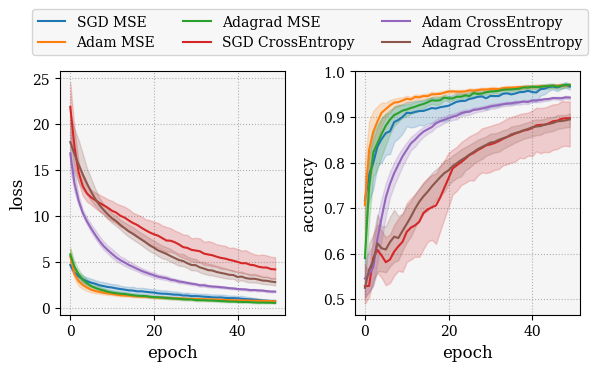

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3.25), dpi=100)

g = sns.lineplot(data=df, x='epoch', y='loss', hue='model', ax=axes[0], legend='brief')
sns.lineplot(data=df, x='epoch', y='accuracy', hue='model', ax=axes[1], legend=False)

h,l = g.axes.get_legend_handles_labels()
g.axes.legend_.remove()
lgd = fig.legend(h,l, ncol=3, bbox_to_anchor=(1.0, 1.15))

plt.tight_layout()
fig.savefig('../figures/training.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=fig.dpi)
plt.show()

# What does our model actually show?

In [17]:
import flame
from flame import nn

from train import train
from utils import load_dataset
from metrics import evaluate_accuracy

In [18]:
train_input, train_target, \
        test_input, test_target, mu, sigma = load_dataset(1000, standardize=True)

In [19]:
model = nn.Sequential([
    nn.Linear(2, 25), nn.ReLU(),
    nn.Linear(25, 25), nn.Dropout(p=0.3), nn.ReLU(),
    nn.Linear(25, 25), nn.ReLU(),
    nn.Linear(25, 1)])

model.init_weights()

model.train()

train(model, train_input, train_target, verbose=1)

Epoch 05 	Loss 14.925 	Acc. 83.700
Epoch 10 	Loss 10.093 	Acc. 88.800
Epoch 15 	Loss 8.302 	Acc. 91.400
Epoch 20 	Loss 7.697 	Acc. 92.900
Epoch 25 	Loss 7.263 	Acc. 94.300
Epoch 30 	Loss 6.841 	Acc. 96.000
Epoch 35 	Loss 6.334 	Acc. 96.200
Epoch 40 	Loss 5.848 	Acc. 97.100
Epoch 45 	Loss 5.553 	Acc. 97.700
Epoch 50 	Loss 5.257 	Acc. 98.500


In [20]:
evaluate_accuracy(model, test_input, test_target).item()

0.9739999771118164

In [21]:
prediction = model(test_input).flatten()

df = pd.DataFrame(test_input.mul_(sigma).add_(mu).tolist())

df['prediction'] = ((prediction > .2).float() + (prediction > .8).float()).tolist()
df['prediction_real'] = prediction.tolist()
df.columns = ['x', 'y', 'prediction', 'prediction_real']

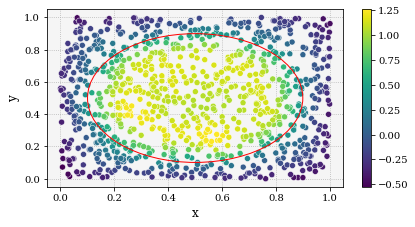

In [22]:
import math

ax = sns.scatterplot(data=df, x='x', y='y', hue='prediction_real', palette='viridis')

norm = plt.Normalize(df['prediction_real'].min(), df['prediction_real'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

circle = plt.Circle((0.5, 0.5), 1 / math.sqrt(2 * math.pi), color='r', fill=False)

ax.add_patch(circle)

plt.tight_layout()

plt.savefig('../figures/test-distribution.png')

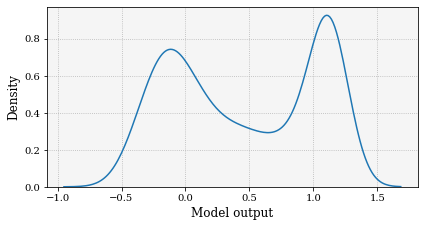

In [23]:
ax = sns.kdeplot(data=df, x='prediction_real', )

ax.set_xlabel('Model output')

plt.tight_layout()

plt.savefig('../figures/output-distribution.png')

In [24]:
prediction = model(test_input).flatten()

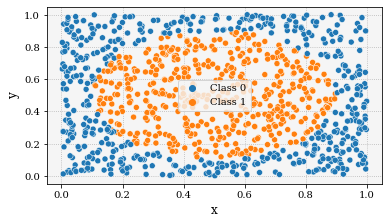

In [57]:

import pandas as pd
train_input, train_target, test_input, test_target= load_dataset(1000, standardize=False)
df = pd.DataFrame(train_input.tolist())

classe= list()
for i in range(train_target.shape[0]):
    if train_target[i]>0.5:
        classe.append("Class 1")
    elif train_target[i]<0.5:
        classe.append("Class 0")

df['Label'] = classe
df.columns = ['x', 'y', 'Label']
SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 16

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_SIZE
mpl.rcParams['axes.titlesize'] = SMALL_SIZE
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = SMALL_SIZE
mpl.rcParams['figure.titlesize'] = LARGE_SIZE

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.facecolor'] = '#F5F5F5'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = [6, 3.259]


sns_plot=sns.scatterplot(data=df, x='x', y='y', hue='Label')
sns_plot.legend(title="",loc='center')
fig = sns_plot.get_figure()
fig.savefig('data.png')

Epoch 05 	Loss 13.890 	Acc. 92.800
Epoch 10 	Loss 9.810 	Acc. 92.100
Epoch 15 	Loss 8.085 	Acc. 94.200
Epoch 20 	Loss 7.020 	Acc. 95.900
Epoch 25 	Loss 6.353 	Acc. 96.700
Epoch 30 	Loss 5.778 	Acc. 98.000
Epoch 35 	Loss 5.072 	Acc. 98.600
Epoch 40 	Loss 4.815 	Acc. 98.500
Epoch 45 	Loss 4.320 	Acc. 98.500
Epoch 50 	Loss 3.890 	Acc. 98.500


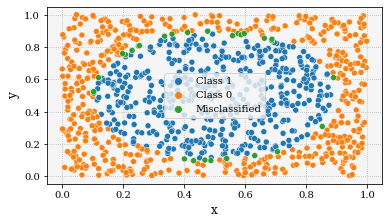

In [65]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys, os
sys.path.append(os.path.abspath('..'))
from torch import manual_seed

from flame import nn
from train import train
from metrics import evaluate_accuracy
from utils import load_dataset

model = nn.Sequential([
    nn.Linear(2, 25), nn.ReLU(),
    nn.Linear(25, 25), nn.Dropout(p=0.3), nn.ReLU(),
    nn.Linear(25, 25), nn.ReLU(),
    nn.Linear(25, 1)])

model.init_weights()

model.train()
train_input, train_target, test_input, test_target, mu, sigma= load_dataset(1000, standardize=True)
train(model, train_input, train_target, verbose=1)




model.train(False)

output = model(test_input).flatten()
test_input.mul_(sigma).add_(mu)
prediction = ((output > .5) == test_target).float()-1
mistakes_idx=prediction.nonzero()
mistakes=test_input[mistakes_idx,:]

test_input=torch.cat((test_input, mistakes.view(-1,2)))
test_target=torch.cat((test_target,-1*torch.ones(mistakes.shape[0])))

classe= list()
for i in range(test_target.shape[0]):
    if test_target[i]<-0.5:
        classe.append("Misclassified")
    elif test_target[i]>0.5:
        classe.append("Class 1")
    elif test_target[i]<0.5 and test_target[i]>-0.5:
        classe.append("Class 0")


SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 16

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_SIZE
mpl.rcParams['axes.titlesize'] = SMALL_SIZE
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = SMALL_SIZE
mpl.rcParams['figure.titlesize'] = LARGE_SIZE

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.facecolor'] = '#F5F5F5'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = [6, 3.259]

df = pd.DataFrame(test_input.tolist())
df['Label'] = classe
df.columns = ['x', 'y', 'Label']

sns_plot=sns.scatterplot(data=df, x='x', y='y', hue='Label')
sns_plot.legend(title="",loc='center')

fig = sns_plot.get_figure()

fig.savefig("test.png")